# Reconstructing PETSIRD Data

PyTomography offers PET listmode, time-of-flight reconstruction capabilities for data in the PETSIRD format. This relatively new data format is being advocated by the Emission Tomography Standardization Initiative (ETSI) to be the standard data format for all PET listmode data. More about ETSI can be found at https://etsinitiative.org/. The goal of ETSI is to standardize PET list mode data, and their current objective is to work with major vendors (such as Siemens, General Electric, United Imaging, Canon Medical Systems, Positrigo, and SynchroPET) to align all output PET data formats. 

**It should be strongly emphasized that this data format is still considered a work-in-progress**. While the data format is still relatively new, PyTomography will continue to add updated support throughout its evolution. The sample PETSIRD data file used in this tutorial was generated during the ETSI hackathon and is the output of a GATE simulation. This tutorial will demonstrate how to reconstruction this data in PyTomography.

A few caveats:
* The establishment of *all valid detector pairs* has not yet been formulated in the PETSIRD format as of yet. For now, it is assumed that all combinations of detector pairs are valid: this is important when computing normalization/sensitivity factors.
* Correction for scatter/randoms has not yet been formulated. Incorporation of these corrections can be expected in future PyTomography versions.

In [1]:
import torch
import pytomography
from pytomography.metadata import ObjectMeta, PETLMProjMeta
from pytomography.projectors import PETLMSystemMatrix
from pytomography.priors import RelativeDifferencePrior
from pytomography.algorithms import BSREM
from pytomography.io.PET import petsird, gate
import os
from pytomography.transforms import GaussianFilter
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib

Specify the path of the PETSIRD file, containing all listmode data:

In [2]:
folder = '/disk1/pytomography_tutorial_data/petsird_tutorial'
petsird_path = os.path.join(folder, 'mIEC_ETSIPETscanner_1.petsird')
eta_path = os.path.join(folder, 'eta.npy')

Here we load all the detector IDs (corresponding to a pair of detectors where an event was measured, along with its time of flight bin) as well as the PETSIRD header, which contains required information about the PET system.

In [3]:
detector_ids, header = petsird.get_detector_ids(
    petsird_path,
    read_tof=True,
    read_energy=False,
    time_block_ids=None,
    return_header=True
)

From the header, we can get our scanner lookup table as well as our time-of-flight metadata

In [4]:
scanner_LUT = petsird.get_scanner_LUT_from_header(header)
tof_meta = petsird.get_TOF_meta_from_header(header)

Define object metadata, which specifies the region of reconstruction

In [5]:
dr = (2.5, 2.5, 2.5)
shape = (128,128,44)
object_meta = ObjectMeta(dr, shape)

Now lets remove all events that are out of bounds of the reconstruction region (important for limited FOV)

In [6]:
detector_ids = gate.remove_events_out_of_bounds(detector_ids, scanner_LUT, object_meta)

Now we setup the projection metadata.

In [7]:
weights_sensitivity = torch.tensor(np.load(eta_path))
proj_meta_nonTOF = PETLMProjMeta(
    detector_ids=detector_ids[:,:2],
    scanner_LUT=scanner_LUT,
    weights_sensitivity=weights_sensitivity)
proj_meta_TOF = PETLMProjMeta(
    detector_ids=detector_ids,
    scanner_LUT=scanner_LUT,
    tof_meta=tof_meta,
    weights_sensitivity=weights_sensitivity)

Load attenuation map generated from the GATE simulation that accompanies this dataset:

In [8]:
amap = gate.get_aligned_attenuation_map('/home/gpuvmadm/PyTomography/notebook_testing/ETSIPET_ACmap_IEC_10cmRadius.hv', object_meta)

Now we can create system matrices that correspond to modeling without and with time of flight (TOF). In the non-TOF matrix, we only give the first two indices of `detector_ids`, (and not the third, which gives the TOF bin).
* For PSF modeling, we'll use a Gaussian filter with 4mm FWHM

In [9]:
psf_transform = GaussianFilter(4)
system_matrix_nontof = PETLMSystemMatrix(
    object_meta,
    proj_meta_nonTOF,
    obj2obj_transforms=[psf_transform],
    attenuation_map=amap,
    N_splits=4
    )
system_matrix_tof = PETLMSystemMatrix(
    object_meta,
    proj_meta_TOF,
    obj2obj_transforms=[psf_transform],
    attenuation_map=amap,
    N_splits=4
    )

For image reconstruction we'll use `BSREM` with the `RelativeDifferencePrior`. Of note: the `projections` argument when reconstructing PET LM data **must be a tensor with the element 1 inside**. This has to do with the fact that the number of observed events along each LOR (which are listed in order) is simply 1 (hence why it was recorded).

In [10]:
prior_rdp = RelativeDifferencePrior(beta=75, gamma=2)
recon_algorithm_nontof = BSREM(
    projections=torch.tensor([1.]).to(pytomography.device),
    system_matrix=system_matrix_nontof,
    prior=prior_rdp,
)
recon_algorithm_tof = BSREM(
    projections=torch.tensor([1.]).to(pytomography.device),
    system_matrix=system_matrix_tof,
    prior=prior_rdp,
)

Now we'll reconstruct for 100 iterations using 1 subset (only 1 subset because the data is noisy)

In [11]:
recon_tof = recon_algorithm_tof(n_iters=100, n_subsets=1)

In [12]:
recon_nontof = recon_algorithm_nontof(n_iters=100, n_subsets=1)

And we can plot the reconstructed objects:

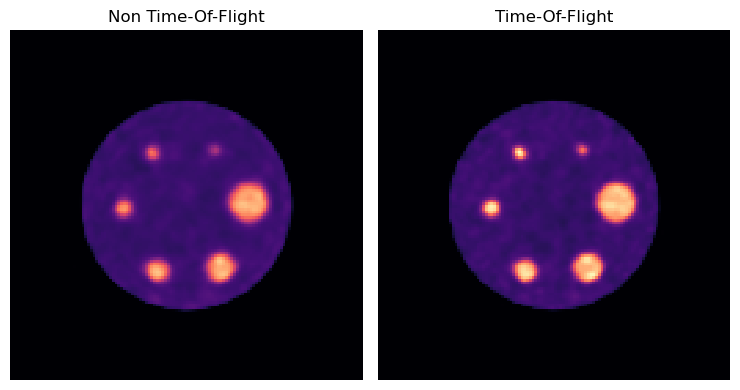

In [13]:
vmax=0.02
slc = 29 
fig, axes = plt.subplots(1,2,figsize=(7.5,4))
plt.subplot(121)
c = plt.pcolormesh(recon_nontof[0,:,:,slc].cpu().T, cmap='magma', vmax=vmax)
plt.axis('off')
plt.title('Non Time-Of-Flight')
plt.subplot(122)
plt.pcolormesh(recon_tof[0,:,:,slc].cpu().T, cmap='magma')
plt.axis('off')
plt.title('Time-Of-Flight')
fig.tight_layout()

We can also save these as nifti files if we want to view them in an external viewing software.

In [14]:
affine=np.eye(4); affine[-1,-1] = 0
recon_tof_nib = nib.Nifti1Image(recon_tof[0].cpu().numpy(), affine=affine)
nib.save(recon_tof_nib, os.path.join(folder, 'bsrem_nopsf_tof.nii.gz'))
recon_nontof_nib = nib.Nifti1Image(recon_nontof[0].cpu().numpy(), affine=affine)
nib.save(recon_nontof_nib, os.path.join(folder, 'bsrem_nopsf_nontof.nii.gz'))

A few current limitations of the PETSIRD format:

* Detector orientation and mean interaction depth in each crystal is not recorded in the detector. As such, the reconstructions may be slightly skewed. This information should be recorded in future PETSIRD versions
* Normalization coefficients for each LOR are not recorded in the header. As such, they need to be manually computed. In this case, they are loaded from a `.npy` file. In future PETSIRD versions, these coefficients should be stored.